<a href="https://colab.research.google.com/github/BrajanNieto/stats-prob-py/blob/main/100.%20PilotoAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
import pandas as pd
from google.colab import files
import io
import numpy as np
from scipy.stats import chi2

Importar Datos

In [100]:
# 1. Sube el archivo
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
print(f"Archivo subido: {file_name}")
df_encuesta = pd.read_excel(io.BytesIO(uploaded[file_name]), sheet_name='Encuesta')


df_encuesta.head()

Saving Encuesta Formato.xlsx to Encuesta Formato (12).xlsx
Archivo subido: Encuesta Formato (12).xlsx


,id,Tipo,Nombres,Apellidos,Sexo,Edad (Años),Peso (kg),Altura (cm),A,B,...,E15,A_Total,C_Total,E_Total,A_Clase,A_Global,C_Clase,C_Global,E_Clase,E_Global
0,1,Cono sur,MIGUEL ANGEL,ZUMARAN RIVERA,M,74,65.0,162,1,1,...,0,10,5,10,2,Existe riesgo social,3,Deterioro moderado,3,Moderado
1,2,Cono sur,SOFIA,RAMIREZ MARTINES,F,64,57.0,153,1,2,...,0,10,4,7,2,Existe riesgo social,2,Deterioro leve,2,Leve
2,3,Cono sur,EMILIA,CHURA CHOQUE,F,72,68.0,154,2,3,...,0,11,4,9,2,Existe riesgo social,2,Deterioro leve,3,Moderado
3,4,Cono sur,GUSTAVO,ZUMARAN RIVERA,M,74,68.0,160,1,1,...,0,10,3,6,2,Existe riesgo social,2,Deterioro leve,2,Leve
4,5,Cono sur,MANUELA,CACERES PEREA,F,85,46.0,148,1,1,...,1,13,7,10,2,Existe riesgo social,3,Deterioro moderado,3,Moderado


# Análisis del Piloto

In [101]:
df_piloto = df_encuesta[df_encuesta['Tipo'] == 'Piloto']
print("Descripción estadística de df_piloto:")
print(df_piloto.describe(include='all'))

Descripción estadística de df_piloto:
               id    Tipo Nombres     Apellidos Sexo  Edad (Años)   Peso (kg)  \
count   29.000000      29      29            29   29    29.000000   29.000000   
unique        NaN       1      25            29    2          NaN         NaN   
top           NaN  Piloto   LUCIA  ARIAS JALIRE    F          NaN         NaN   
freq          NaN      29       2             1   27          NaN         NaN   
mean    15.310345     NaN     NaN           NaN  NaN    69.931034   65.439655   
std      8.896642     NaN     NaN           NaN  NaN     5.463718   12.107232   
min      1.000000     NaN     NaN           NaN  NaN    60.000000   49.000000   
25%      8.000000     NaN     NaN           NaN  NaN    66.000000   56.000000   
50%     15.000000     NaN     NaN           NaN  NaN    70.000000   65.000000   
75%     23.000000     NaN     NaN           NaN  NaN    73.000000   70.000000   
max     30.000000     NaN     NaN           NaN  NaN    83.000000  100.

In [102]:
print("\nNulos por columna en df_piloto:")
print(df_piloto.isnull().sum())


Nulos por columna en df_piloto:
id           0
Tipo         0
Nombres      0
Apellidos    0
Sexo         0
            ..
A_Global     0
C_Clase      0
C_Global     0
E_Clase      0
E_Global     0
Length: 72, dtype: int64


In [103]:
print("\nColumnas de df_piloto:")
print(", ".join(df_piloto.columns))


Columnas de df_piloto:
id, Tipo, Nombres, Apellidos, Sexo, Edad (Años), Peso (kg), Altura (cm), A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, Cribaje, Evaluación, Global, Cribaje_Clase, Cribaje_Descripción, Evaluación_Clase, Evaluación_Descripción, A1, A2, A3, A4, A5, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, E15, A_Total, C_Total, E_Total, A_Clase, A_Global, C_Clase, C_Global, E_Clase, E_Global


## Validación del Constructo

### Bartlett

In [104]:
# ─────────────────────────────────────────────
# 1.  Test de esfericidad de Bartlett
# ─────────────────────────────────────────────
def bartlett_sphericity(df: pd.DataFrame,
                        items: list[str],
                        *,
                        verbose: bool = True):
    """
    χ² de Bartlett para una lista de ítems.
    --------------------------------------
    Retorna: (chi_cuadrado, grados_libertad, p_valor, const_cols_eliminadas)
    """
    data = df[items].astype(float).dropna()

    # 1. Quitar columnas constantes
    const_cols = data.columns[data.nunique() == 1].tolist()
    if const_cols and verbose:
        print(f"[Bartlett] Columnas constantes eliminadas: {const_cols}")
    data = data.drop(columns=const_cols)

    n, p = data.shape
    if p < 2:
        raise ValueError("Quedaron <2 ítems tras eliminar constantes.")
    if n <= p:
        raise ValueError("n ≤ p: la matriz de correlaciones no es invertible.")

    # 2. Matriz de correlaciones
    R = data.corr()

    # 3. Estadístico de Bartlett
    det_R = np.linalg.det(R)
    if det_R <= 0:
        raise ValueError("Determinante ≤ 0: matriz singular o no positiva definida.")
    chi_square = -(n - 1 - (2 * p + 5) / 6) * np.log(det_R)
    dof = p * (p - 1) / 2
    p_val = 1 - chi2.cdf(chi_square, dof)

    return chi_square, dof, p_val, const_cols


### KMO

In [105]:

# ─────────────────────────────────────────────
# 2.  Índice KMO global e individual
# ─────────────────────────────────────────────
def kmo_test(df: pd.DataFrame,
             items: list[str],
             *,
             verbose: bool = True):
    """
    KMO global y por ítem.
    ----------------------
    Retorna: (kmo_global, serie_kmo_individual, const_cols_eliminadas)
    """
    data = df[items].astype(float).dropna()

    # 1. Quitar columnas constantes
    const_cols = data.columns[data.nunique() == 1].tolist()
    if const_cols and verbose:
        print(f"[KMO] Columnas constantes eliminadas: {const_cols}")
    data = data.drop(columns=const_cols)

    n, p = data.shape
    if p < 2:
        raise ValueError("Quedaron <2 ítems tras eliminar constantes.")
    if n <= p:
        raise ValueError("n ≤ p: la matriz de correlaciones no es invertible.")

    # 2. Matriz de correlaciones
    R = data.corr()

    # 3. Matriz de correlaciones parciales
    inv_R = np.linalg.inv(R)
    partial = -inv_R / np.sqrt(np.outer(np.diag(inv_R), np.diag(inv_R)))
    np.fill_diagonal(partial, 0)

    # 4. KMO global
    corr_sq = (R.values[np.triu_indices(p, 1)] ** 2).sum()
    part_sq = (partial[np.triu_indices(p, 1)] ** 2).sum()
    kmo_global = corr_sq / (corr_sq + part_sq)

    # 5. KMO por ítem
    kmo_individual = {}
    for i, col in enumerate(R.columns):
        corr_sq_i = (R.iloc[i, :].drop(index=col) ** 2).sum()
        part_sq_i = (partial[i, :] ** 2).sum()
        kmo_individual[col] = corr_sq_i / (corr_sq_i + part_sq_i)

    kmo_series = pd.Series(kmo_individual, name="KMO_individual")

    return kmo_global, kmo_series, const_cols

### Analisis del constructo

In [107]:
# Definición de ítems para cada escala
vdependiente1_cols = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R']
vindependiente1_cols = ['A1','A2','A3','A4','A5']
vindependiente2_cols = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
vindependiente3_cols = ['E1','E2','E3','E4','E5','E6','E7','E8','E9','E10','E11','E12','E13','E14','E15']

# 1. Variable dependiente (Estado nutricional)
print("Análisis del constructo /n")

print("Variable dependiente /n")
chi2_dv, dof_dv, p_b_dv, const_b_dv = bartlett_sphericity(df_piloto, vdependiente1_cols)
print(f"[Dependiente] Bartlett χ²({int(dof_dv)}) = {chi2_dv:.2f}, p = {p_b_dv:.5e}")
kmo_g_dv, kmo_i_dv, const_k_dv = kmo_test(df_piloto, vdependiente1_cols)
print(f"[Dependiente] KMO global = {kmo_g_dv:.3f}")
print("[Dependiente] KMO individual:")
print(kmo_i_dv.round(3))

print("Variable independiente /n")

print('Analisis del Factor sociofamiliar – Escala de Gijón')

# 2. Independiente 1 (Factor sociofamiliar – Escala de Gijón)
chi2_i1, dof_i1, p_b_i1, const_b_i1 = bartlett_sphericity(df_piloto, vindependiente1_cols)
print(f"[Indep1] Bartlett χ²({int(dof_i1)}) = {chi2_i1:.2f}, p = {p_b_i1:.5e}")
kmo_g_i1, kmo_i_i1, const_k_i1 = kmo_test(df_piloto, vindependiente1_cols)
print(f"[Indep1] KMO global = {kmo_g_i1:.3f}")
print("[Indep1] KMO individual:")
print(kmo_i_i1.round(3))

print('Analisis del  Estado cognitivo – SPMSQ')

# 3. Independiente 2 (Estado cognitivo – SPMSQ)
chi2_i2, dof_i2, p_b_i2, const_b_i2 = bartlett_sphericity(df_piloto, vindependiente2_cols)
print(f"[Indep2] Bartlett χ²({int(dof_i2)}) = {chi2_i2:.2f}, p = {p_b_i2:.5e}")
kmo_g_i2, kmo_i_i2, const_k_i2 = kmo_test(df_piloto, vindependiente2_cols)
print(f"[Indep2] KMO global = {kmo_g_i2:.3f}")
print("[Indep2] KMO individual:")
print(kmo_i_i2.round(3))

print('Analisis del Escala de depresión – Yesavag')

# 4. Independiente 3 (Escala de depresión – Yesavage)
chi2_i3, dof_i3, p_b_i3, const_b_i3 = bartlett_sphericity(df_piloto, vindependiente3_cols)
print(f"[Indep3] Bartlett χ²({int(dof_i3)}) = {chi2_i3:.2f}, p = {p_b_i3:.5e}")
kmo_g_i3, kmo_i_i3, const_k_i3 = kmo_test(df_piloto, vindependiente3_cols)
print(f"[Indep3] KMO global = {kmo_g_i3:.3f}")
print("[Indep3] KMO individual:")
print(kmo_i_i3.round(3))


Análisis del constructo /n
Variable dependiente /n
[Bartlett] Columnas constantes eliminadas: ['G', 'I', 'Q']
[Dependiente] Bartlett χ²(105) = 272.14, p = 1.11022e-16
[KMO] Columnas constantes eliminadas: ['G', 'I', 'Q']
[Dependiente] KMO global = 0.448
[Dependiente] KMO individual:
A    0.799
B    0.760
C    0.443
D    0.733
E    0.485
F    0.288
H    0.304
J    0.395
K    0.611
L    0.215
M    0.367
N    0.425
O    0.758
P    0.241
R    0.166
Name: KMO_individual, dtype: float64
Variable independiente /n
Analisis del Factor sociofamiliar – Escala de Gijón
[Indep1] Bartlett χ²(10) = 14.21, p = 1.63563e-01
[Indep1] KMO global = 0.472
[Indep1] KMO individual:
A1    0.475
A2    0.441
A3    0.495
A4    0.435
A5    0.506
Name: KMO_individual, dtype: float64
Analisis del  Estado cognitivo – SPMSQ
[Bartlett] Columnas constantes eliminadas: ['C5']
[Indep2] Bartlett χ²(36) = 92.69, p = 6.83768e-07
[KMO] Columnas constantes eliminadas: ['C5']
[Indep2] KMO global = 0.623
[Indep2] KMO individual:

Columnas constantes eliminadas antes del PCA: ['C5']


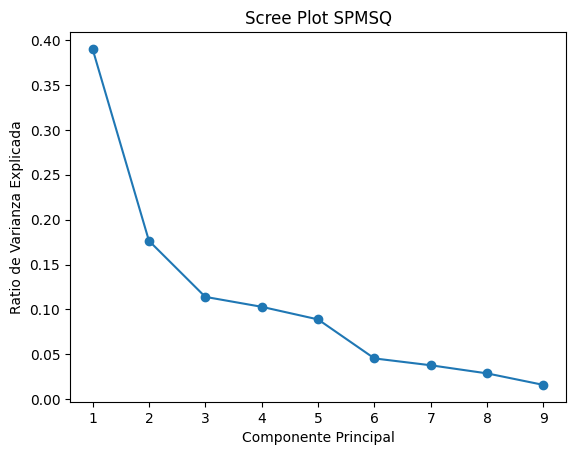

Varianza explicada por componente:
 PC1    0.390
PC2    0.176
PC3    0.114
PC4    0.103
PC5    0.089
PC6    0.045
PC7    0.038
PC8    0.029
PC9    0.016
dtype: float64

Varianza explicada acumulada:
 PC1    0.390
PC2    0.567
PC3    0.681
PC4    0.784
PC5    0.872
PC6    0.918
PC7    0.955
PC8    0.984
PC9    1.000
dtype: float64
Se seleccionan 5 componentes que explican al menos el 80% de la varianza.

Cargas factoriales:
        PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8    PC9
C1   0.456 -0.022  0.179  0.222  0.096  0.062 -0.388  0.674  0.305
C2   0.253  0.527 -0.056 -0.297 -0.375 -0.514  0.010  0.218 -0.338
C3   0.421  0.228 -0.036 -0.453  0.057  0.093  0.102 -0.366  0.639
C4   0.335 -0.397  0.149  0.185 -0.398 -0.050  0.707  0.105  0.050
C6  -0.145  0.559 -0.412  0.364  0.186  0.214  0.446  0.247  0.153
C7   0.399 -0.129 -0.401 -0.278  0.033  0.589 -0.021  0.071 -0.482
C8   0.326  0.012 -0.383  0.589 -0.277 -0.131 -0.320 -0.452  0.013
C9   0.346 -0.094  0.001  0.092  0.7

In [110]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# 1. Definir los ítems SPMSQ
vindependiente2_cols = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']

# 2. Preparar los datos: seleccionar, convertir a float, eliminar NAs y constantes
data_spmsq = df_piloto[vindependiente2_cols].astype(float).dropna()
const_cols = data_spmsq.columns[data_spmsq.nunique() == 1].tolist()
print(f"Columnas constantes eliminadas antes del PCA: {const_cols}")
data_spmsq = data_spmsq.drop(columns=const_cols)

# 3. Estandarizar
scaler = StandardScaler()
X = scaler.fit_transform(data_spmsq)

# 4. Ajustar PCA
pca = PCA()
pca.fit(X)

# 5. Scree plot (varianza explicada por componente)
plt.figure()
components = range(1, len(pca.explained_variance_ratio_) + 1)
plt.plot(components, pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot SPMSQ')
plt.xlabel('Componente Principal')
plt.ylabel('Ratio de Varianza Explicada')
plt.xticks(components)
plt.show()

# 6. Imprimir varianza explicada acumulada
explained = pd.Series(pca.explained_variance_ratio_,
                      index=[f'PC{i}' for i in components])
print("Varianza explicada por componente:\n", explained.round(3))
print("\nVarianza explicada acumulada:\n", explained.cumsum().round(3))

# 6.5 Seleccionar componentes que suman al menos el 80% de la varianza
varianza_acumulada = explained.cumsum()
num_componentes_80 = varianza_acumulada[varianza_acumulada <= 0.80].count() + 1
print(f"Se seleccionan {num_componentes_80} componentes que explican al menos el 80% de la varianza.")


# 7. Cargas factoriales (loadings)
loadings = pd.DataFrame(pca.components_.T,
                        index=data_spmsq.columns,
                        columns=[f'PC{i}' for i in components])
print("\nCargas factoriales:\n", loadings.round(3))


In [109]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Definir los ítems SPMSQ
vindependiente2_cols = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']

# 2. Preparar y estandarizar los datos
data_spmsq = df_piloto[vindependiente2_cols].astype(float).dropna()
const_cols = data_spmsq.columns[data_spmsq.nunique() == 1].tolist()
print(f"Columnas constantes eliminadas antes del PCA: {const_cols}")
data_spmsq = data_spmsq.drop(columns=const_cols)

scaler = StandardScaler()
X = scaler.fit_transform(data_spmsq)

# 3. Ajustar PCA
pca = PCA()
pca.fit(X)

# 4. Resumen de componentes
eigenvalues   = pca.explained_variance_
var_ratio     = pca.explained_variance_ratio_
cum_var_ratio = var_ratio.cumsum()

# 5. Cargas factoriales (loadings)
#    loadings = eigenvectors * sqrt(eigenvalues)
loadings = pca.components_.T * np.sqrt(eigenvalues)

# 6. Suma de cargas al cuadrado por componente
sum_sq_loadings = (loadings**2).sum(axis=0)

# 7. Construir DataFrame resumen
summary = pd.DataFrame({
    'Eigenvalue':           eigenvalues,
    '% Variance':           var_ratio * 100,
    '% Cumulative':         cum_var_ratio * 100,
    'Sum Squared Loadings': sum_sq_loadings
}, index=[f'PC{i+1}' for i in range(len(eigenvalues))])

print(summary.round(3))


Columnas constantes eliminadas antes del PCA: ['C5']
     Eigenvalue  % Variance  % Cumulative  Sum Squared Loadings
PC1       3.638      39.026        39.026                 3.638
PC2       1.645      17.645        56.672                 1.645
PC3       1.062      11.395        68.067                 1.062
PC4       0.959      10.289        78.356                 0.959
PC5       0.828       8.883        87.239                 0.828
PC6       0.423       4.537        91.776                 0.423
PC7       0.352       3.774        95.549                 0.352
PC8       0.267       2.868        98.417                 0.267
PC9       0.148       1.583       100.000                 0.148


In [111]:

# 2. Independiente 1 (Factor sociofamiliar – Escala de Gijón)
chi2_i1, dof_i1, p_b_i1, const_b_i1 = bartlett_sphericity(df_piloto, vindependiente1_cols)
print(f"[Indep1] Bartlett χ²({int(dof_i1)}) = {chi2_i1:.2f}, p = {p_b_i1:.5e}")
kmo_g_i1, kmo_i_i1, const_k_i1 = kmo_test(df_piloto, vindependiente1_cols)
print(f"[Indep1] KMO global = {kmo_g_i1:.3f}")
print("[Indep1] KMO individual:")
print(kmo_i_i1.round(3))

print('Analisis del  Estado cognitivo – SPMSQ')

# 3. Independiente 2 (Estado cognitivo – SPMSQ)
chi2_i2, dof_i2, p_b_i2, const_b_i2 = bartlett_sphericity(df_piloto, vindependiente2_cols)
print(f"[Indep2] Bartlett χ²({int(dof_i2)}) = {chi2_i2:.2f}, p = {p_b_i2:.5e}")
kmo_g_i2, kmo_i_i2, const_k_i2 = kmo_test(df_piloto, vindependiente2_cols)
print(f"[Indep2] KMO global = {kmo_g_i2:.3f}")
print("[Indep2] KMO individual:")
print(kmo_i_i2.round(3))

print('Analisis del Escala de depresión – Yesavag')

# 4. Independiente 3 (Escala de depresión – Yesavage)
chi2_i3, dof_i3, p_b_i3, const_b_i3 = bartlett_sphericity(df_piloto, vindependiente3_cols)
print(f"[Indep3] Bartlett χ²({int(dof_i3)}) = {chi2_i3:.2f}, p = {p_b_i3:.5e}")
kmo_g_i3, kmo_i_i3, const_k_i3 = kmo_test(df_piloto, vindependiente3_cols)
print(f"[Indep3] KMO global = {kmo_g_i3:.3f}")
print("[Indep3] KMO individual:")
print(kmo_i_i3.round(3))


[Indep1] Bartlett χ²(10) = 14.21, p = 1.63563e-01
[Indep1] KMO global = 0.472
[Indep1] KMO individual:
A1    0.475
A2    0.441
A3    0.495
A4    0.435
A5    0.506
Name: KMO_individual, dtype: float64
Analisis del  Estado cognitivo – SPMSQ
[Bartlett] Columnas constantes eliminadas: ['C5']
[Indep2] Bartlett χ²(36) = 92.69, p = 6.83768e-07
[KMO] Columnas constantes eliminadas: ['C5']
[Indep2] KMO global = 0.623
[Indep2] KMO individual:
C1     0.723
C2     0.538
C3     0.602
C4     0.730
C6     0.431
C7     0.635
C8     0.679
C9     0.684
C10    0.403
Name: KMO_individual, dtype: float64
Analisis del Escala de depresión – Yesavag
[Indep3] Bartlett χ²(105) = 299.65, p = 0.00000e+00
[Indep3] KMO global = 0.371
[Indep3] KMO individual:
E1     0.365
E2     0.124
E3     0.538
E4     0.463
E5     0.512
E6     0.449
E7     0.522
E8     0.229
E9     0.306
E10    0.485
E11    0.786
E12    0.304
E13    0.543
E14    0.264
E15    0.204
Name: KMO_individual, dtype: float64


In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.linalg import svd

def varimax(loadings, gamma=1.0, q=20, tol=1e-6):
    R = np.eye(loadings.shape[1])
    for _ in range(q):
        lam = loadings @ R
        u, _, v = svd(loadings.T @ (lam**3 - (gamma / loadings.shape[0]) *
                                    lam @ np.diag(np.sum(lam**2, axis=0))))
        R_new = u @ v
        if np.max(np.abs(R - R_new)) < tol:
            break
        R = R_new
    return loadings @ R, R

def pca_report(df, cols, variance_threshold=0.80, rotate=True, random_state=None):
    X = df[cols].copy()

    # 1. Quitar columnas constantes y filas con NA
    const_cols = X.columns[X.nunique() <= 1].tolist()
    if const_cols:
        print(f"[PCA] columnas constantes eliminadas: {const_cols}")
        X = X.drop(columns=const_cols)
    X = X.dropna()

    # 2. Estandarizar
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    # 3. PCA con todas las comp.
    pca_full = PCA(random_state=random_state).fit(X_std)
    eigval = pca_full.explained_variance_
    ratio = pca_full.explained_variance_ratio_
    cum_ratio = ratio.cumsum()

    eig_df = (pd.DataFrame({"Autovalor": eigval,
                            "% Var.Exp": ratio,
                            "% Var.Acum": cum_ratio})
              .assign(Componente=lambda d: np.arange(1, len(d)+1))
              .set_index("Componente"))

    # 4. Scree plot
    plt.figure()
    plt.plot(eig_df.index, eig_df["Autovalor"], marker="o")
    plt.axhline(1, ls="--")
    plt.xlabel("Componente"); plt.ylabel("Autovalor")
    plt.title("Scree plot")
    plt.show()

    # 5. Nº de componentes
    n_ret = max(1, (cum_ratio <= variance_threshold).sum())
    print(f"[PCA] Componentes retenidas: {n_ret} "
          f"({cum_ratio[n_ret-1]:.2%} var. acumulada)")

    # 6. PCA restringido
    pca = PCA(n_components=n_ret, random_state=random_state).fit(X_std)

    # --> Cargas (variables × componentes)
    loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_),
                            index=X.columns,
                            columns=[f"PC{i+1}" for i in range(n_ret)])

    # 7. Rotación opcional
    loadings_rot = None
    if rotate and n_ret > 1:
        Lrot, _ = varimax(loadings.values)
        loadings_rot = pd.DataFrame(Lrot,
                                    index=loadings.index,
                                    columns=loadings.columns)
        load_plot = loadings_rot
    else:
        load_plot = loadings

    # 8. Heat-map de cargas
    plt.figure(figsize=(1.2*n_ret, 0.5*len(load_plot)))
    plt.imshow(load_plot, aspect="auto")
    plt.xticks(range(n_ret), load_plot.columns)
    plt.yticks(range(len(load_plot)), load_plot.index)
    plt.colorbar(label="Carga")
    plt.title("Cargas" + (" (rotadas)" if rotate and n_ret > 1 else ""))
    plt.show()

    # 9. Tabla de varianza (estilo SPSS)
    var_tbl = eig_df.iloc[:n_ret].copy()
    var_tbl[["% Var.Exp", "% Var.Acum"]] *= 100
    print("\n[Matriz total de varianza explicada]\n")
    display(var_tbl.round(2))

    # 10. Comunalidades
    communal = (load_plot**2).sum(axis=1).to_frame("Comunalidad")
    print("\n[Comunalidades]\n")
    display(communal.round(3))

    # 11. Matriz de componentes
    print("\n[Matriz de componentes]\n")
    display(load_plot.round(3))

    return {"eigenvalues": eig_df,
            "loadings": loadings,
            "loadings_rot": loadings_rot,
            "communalities": communal,
            "components_retained": n_ret}

# Ejemplo:
# info = pca_report(df_piloto, vindependiente2_cols, variance_threshold=0.80)


In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.validation import check_is_fitted
from scipy.linalg import svd

def varimax(loadings, gamma=1.0, q=20, tol=1e-6):
    """
    Simple varimax rotation (orthogonal).
    Returns rotated loadings and the rotation matrix.
    """
    R = np.eye(loadings.shape[1])
    for _ in range(q):
        lam = loadings @ R
        u, s, v = svd(loadings.T @ (lam**3 - (gamma/ loadings.shape[0]) * lam @ np.diag(np.sum(lam**2, axis=0))))
        R_new = u @ v
        if np.max(np.abs(R - R_new)) < tol:
            break
        R = R_new
    return loadings @ R, R

def pca_report(df: pd.DataFrame,
               cols: list[str],
               variance_threshold: float = 0.80,
               rotate: bool = True,
               random_state: int | None = None):
    """
    Performs PCA and returns:
      scree plot, eigenvalues table, loadings plot,
      total explained variance table, communalities and component matrix.

    Parameters
    ----------
    df : DataFrame
        Source data.
    cols : list[str]
        Column names to include in the PCA.
    variance_threshold : float, default 0.80
        Desired cumulative explained variance (<= threshold).
    rotate : bool, default True
        Apply varimax rotation to retained components.
    random_state : int | None
        Reproducibility for sklearn PCA.

    Returns
    -------
    dict
        {
          "eigenvalues"        : DataFrame,
          "loadings"           : DataFrame,
          "loadings_rot"       : DataFrame | None,
          "communalities"      : Series,
          "components_retained": int
        }
    """
    X = df[cols].copy()

    # 1. Clean constant columns and drop NAs
    nunique = X.nunique()
    constant_cols = nunique[nunique <= 1].index.tolist()
    if constant_cols:
        print(f"[PCA] columnas constantes eliminadas: {constant_cols}")
        X = X.drop(columns=constant_cols)
    X = X.dropna()

    # 2. Standardize
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    # 3. PCA fit (all components)
    pca_full = PCA(random_state=random_state).fit(X_std)
    eigenvalues = pca_full.explained_variance_
    explained_ratio = pca_full.explained_variance_ratio_
    cum_ratio = explained_ratio.cumsum()

    eig_df = (pd.DataFrame({
        "Componente": np.arange(1, len(eigenvalues)+1),
        "Autovalor": eigenvalues,
        "% Var.Exp": explained_ratio,
        "% Var.Acum": cum_ratio})
        .set_index("Componente"))

    # 4. Scree plot
    plt.figure()
    plt.plot(eig_df.index, eig_df["Autovalor"], marker="o")
    plt.xlabel("Componente")
    plt.ylabel("Autovalor")
    plt.title("Diagrama de sedimentación (Scree plot)")
    plt.axhline(1, linestyle="--")  # criterio de Kaiser
    plt.show()

    # 5. Determine number of components (≤ threshold)
    n_retained = (cum_ratio <= variance_threshold).sum()
    if n_retained == 0:  # siempre conservar al menos una
        n_retained = 1
    print(f"[PCA] Componentes retenidas: {n_retained} "
          f"({cum_ratio[n_retained-1]:.2%} var. acumulada)")

    # 6. PCA restricted to retained comps
    pca = PCA(n_components=n_retained, random_state=random_state)
    loadings = pd.DataFrame(
        pca.fit_transform(X_std).T @ np.diag(1/np.sqrt(pca.explained_variance_)),
        index=[f"PC{i+1}" for i in range(n_retained)],
        columns=X.columns).T  # variables x componentes

    # Varimax rotation (optional)
    loadings_rot = None
    if rotate:
        L_rot, _ = varimax(loadings.values)
        loadings_rot = pd.DataFrame(
            L_rot, index=loadings.index, columns=loadings.columns)
        loadings_plot = loadings_rot
    else:
        loadings_plot = loadings

    # 7. Loadings heat-map
    plt.figure(figsize=(1.2 * n_retained, 0.5 * len(loadings_plot)))
    plt.imshow(loadings_plot, aspect="auto")
    plt.yticks(range(len(loadings_plot)), loadings_plot.index)
    plt.xticks(range(n_retained), loadings_plot.columns)
    plt.colorbar(label="Carga")
    plt.title("Gráfico de cargas" + (" (rotadas)" if rotate else ""))
    plt.show()

    # 8. Total variance table (SPSS style)
    var_table = eig_df.iloc[:n_retained].copy()
    var_table.loc[:, ["% Var.Exp", "% Var.Acum"]] *= 100
    print("\n[Matriz total de varianza explicada]\n")
    display(var_table)

    # 9. Communalities
    communalities = (loadings_plot**2).sum(axis=1)
    comm_df = communalities.to_frame("Comunalidad")
    print("\n[Comunidades]\n")
    display(comm_df.round(3))

    # 10. Component matrix
    print("\n[Matriz de componentes]\n")
    display(loadings_plot.round(3))

    return {
        "eigenvalues": eig_df,
        "loadings": loadings,
        "loadings_rot": loadings_rot,
        "communalities": communalities,
        "components_retained": n_retained
    }

# === Ejemplo de uso ===



[PCA] columnas constantes eliminadas: ['C5']


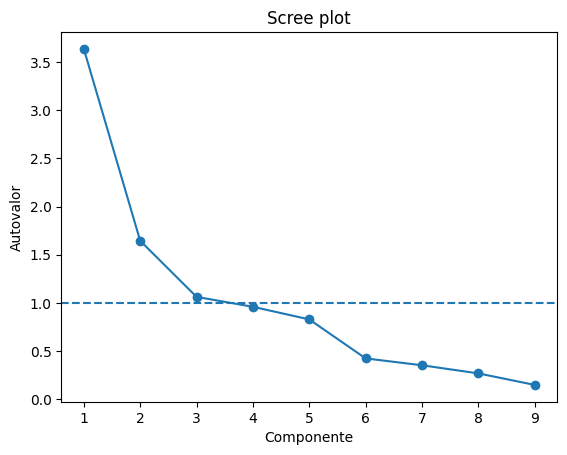

[PCA] Componentes retenidas: 4 (78.36% var. acumulada)


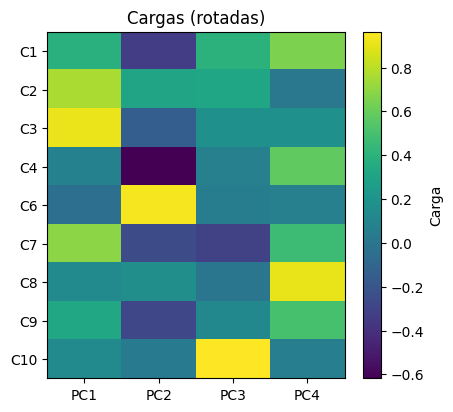


[Matriz total de varianza explicada]



,Autovalor,% Var.Exp,% Var.Acum
Componente,,,
1,3.64,39.03,39.03
2,1.64,17.65,56.67
3,1.06,11.40,68.07
4,0.96,10.29,78.36



[Comunalidades]



,Comunalidad
C1,0.839
C2,0.778
C3,0.930
C4,0.725
C6,0.898
C7,0.852
C8,0.874
C9,0.457
C10,0.951



[Matriz de componentes]



,PC1,PC2,PC3,PC4
C1,0.385,-0.328,0.395,0.653
C2,0.766,0.305,0.314,0.013
C3,0.920,-0.146,0.175,0.178
C4,0.080,-0.618,0.072,0.576
C6,-0.042,0.943,0.050,0.068
C7,0.688,-0.254,-0.309,0.468
C8,0.134,0.165,0.001,0.911
C9,0.329,-0.280,0.120,0.506
C10,0.137,0.029,0.963,0.060


In [117]:
 info = pca_report(df_piloto, vindependiente2_cols, variance_threshold=0.80)